In [8]:
from ROOT import TFile, TCanvas, gROOT
import sys, ROOT, matplotlib, math
import numpy as np
from setStyle import setStyle, CompLegend
gROOT.SetBatch()
setStyle()
inF = TFile.Open('../../../MLandHPC/code/stepAna/TrackHistograms.root')
hist = inF.Get('volumes/EMEC/trackStepsWgt/EMEC_gamma_vol_trackStepsWgt')
tempStepNum = []
tempCompCost = []
for binI in range(1, hist.GetNbinsX()+1):
    tempStepNum.append(hist.GetBinLowEdge(binI)+(hist.GetBinWidth(binI)/2.))
    tempCompCost.append(hist.GetBinContent(binI))
stepNum = np.array(tempStepNum)
compCost = np.array(tempCompCost)   

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [28]:
# This is ugly (there must be a more elegant way to do this)
def reduceStep(stepNums, stepReduction, inferencePenalty=1):
    newStepNums = []
    for i in stepNums:
        newStepNum = i
        if i > stepReduction:
            if i % stepReduction == 0:
                newStepNum = (i-1) % (stepReduction) + math.floor((i-1)/(stepReduction))*inferencePenalty+1
            else:
                newStepNum = i % (stepReduction) + math.floor(i/(stepReduction))*inferencePenalty
        newStepNums.append(newStepNum)
    return np.array(newStepNums)

Total improvement: 72%


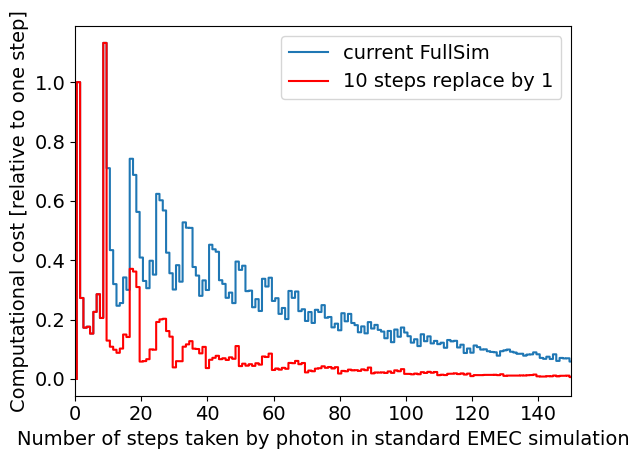

In [29]:
stepReduction = 10
newSteps = reduceStep(stepNum+.5, stepReduction, inferencePenalty=1)
improvement = newSteps/(stepNum+.5)
fig, ax = plt.subplots()
newCompCost = compCost*improvement
plt.step(stepNum, compCost/compCost[1], label='current FullSim')
plt.step(stepNum, newCompCost/newCompCost[1], color='red', label='10 steps replace by 1')
ax.set_xlabel('Number of steps taken by photon in standard EMEC simulation')
ax.set_ylabel('Computational cost [relative to one step]')
ax.legend(loc=0)
maxStep = 150
ax.set_xlim((0,maxStep))
plt.savefig(f'compCost.pdf', bbox_inches='tight')
plt.savefig(f'compCost.svg', bbox_inches='tight')
totalCompImprov = int(round((1-np.sum(newCompCost)/np.sum(compCost))*100))
print(f'Total improvement: {totalCompImprov}%')

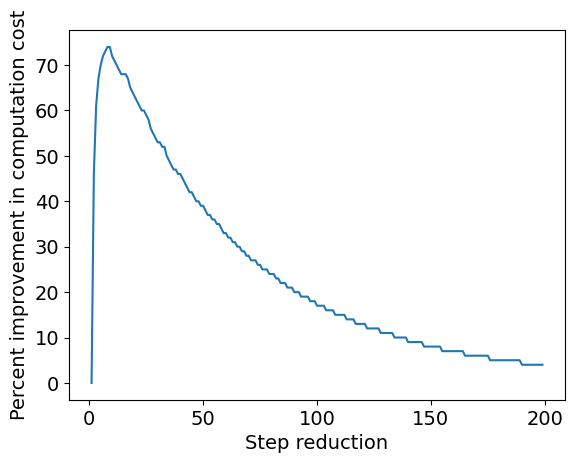

In [30]:
# Now let's plot the improvement as a function in step reduction
stepReductions = [i for i in range(1,200)]
totalCompImprovs = []
for stepReduction in stepReductions:
    newSteps = reduceStep(stepNum+.5, stepReduction, inferencePenalty=1)
    improvement = newSteps/(stepNum+.5)
    newCompCost = compCost*improvement
    totalCompImprovs.append(int(round((1-np.sum(newCompCost)/np.sum(compCost))*100)))

fig, ax = plt.subplots()
plt.plot(stepReductions, totalCompImprovs)
ax.set_xlabel('Step reduction')
ax.set_ylabel('Percent improvement in computation cost')
plt.savefig(f'compCostVsStepRed.pdf', bbox_inches='tight')
plt.savefig(f'compCostVsStepRed.svg', bbox_inches='tight')


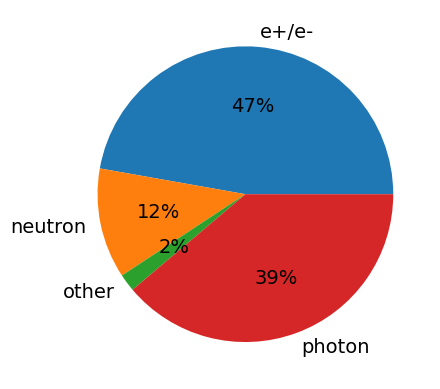

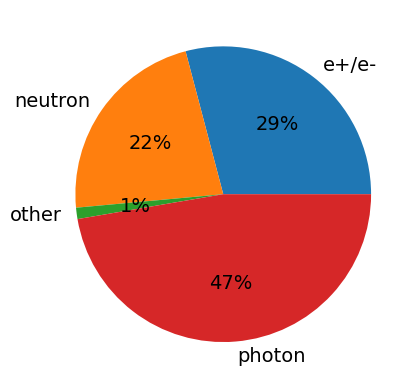

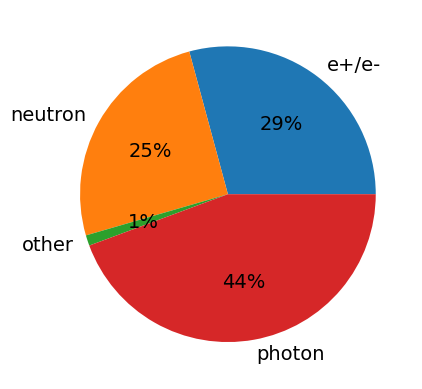

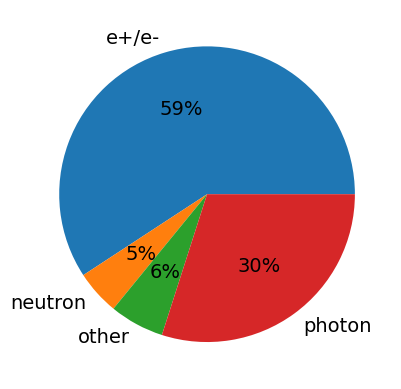

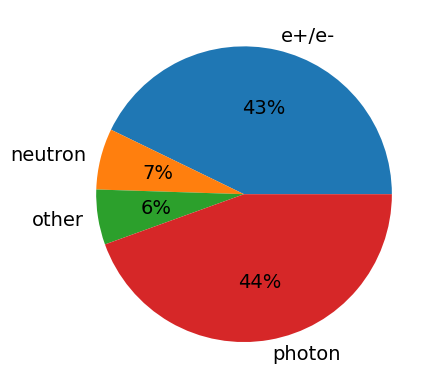

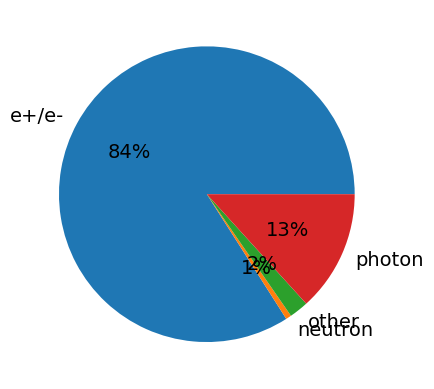

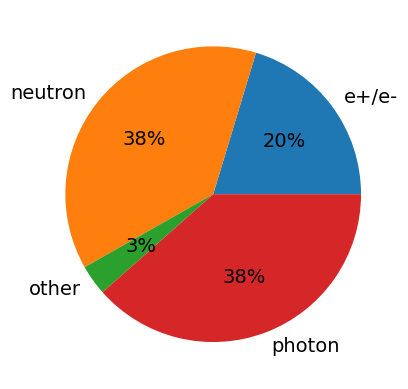

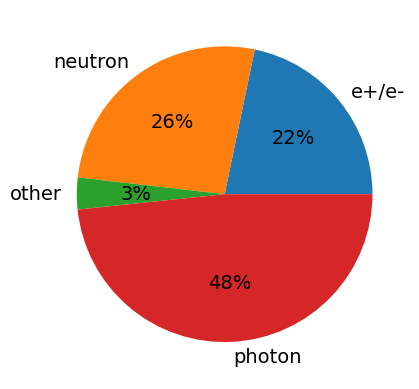

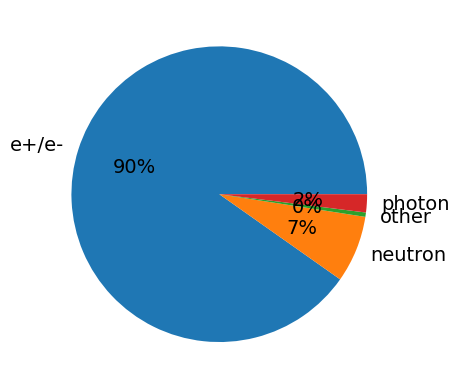

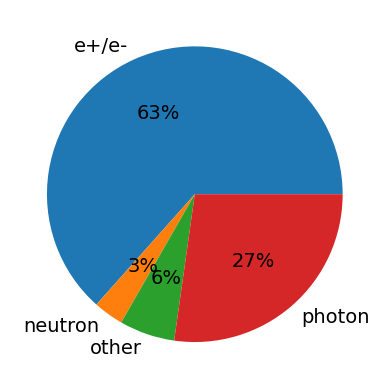

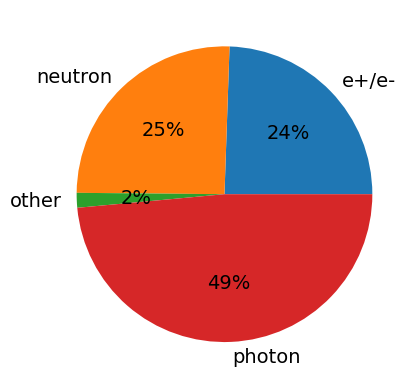

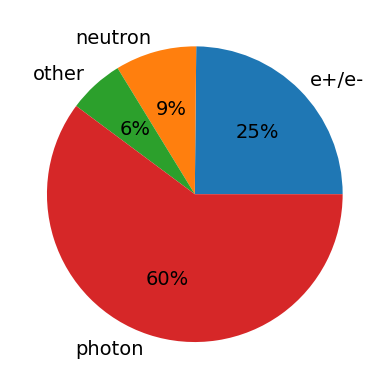

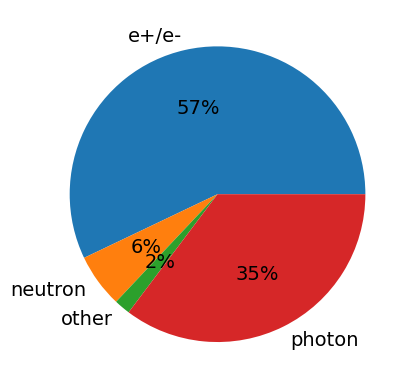

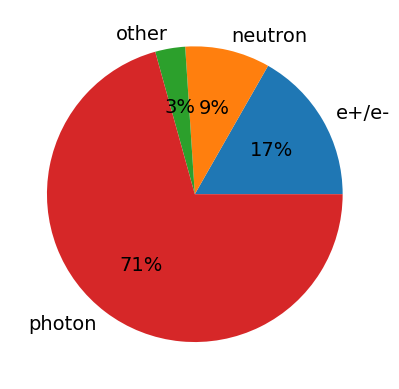

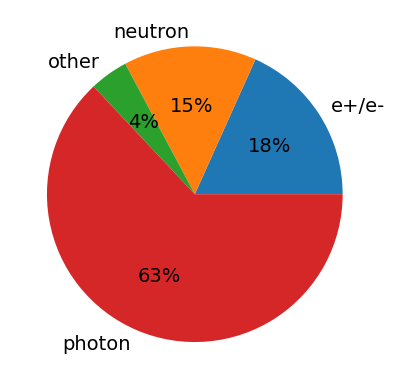

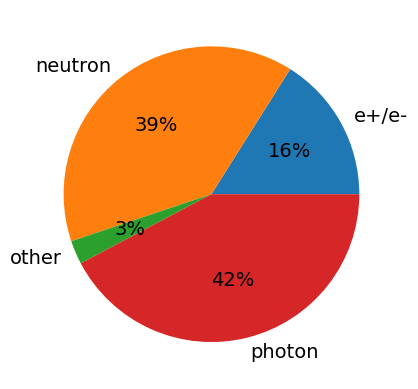

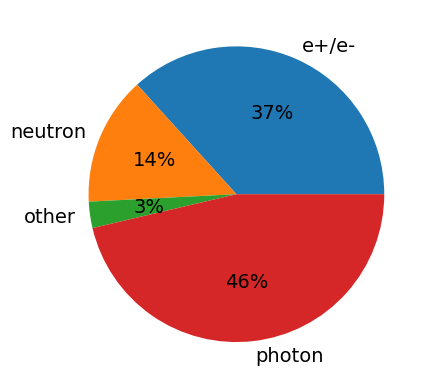

In [31]:
totalCosts = []
volDir = inF.Get("volumes")
volKeys = volDir.GetListOfKeys()
volNames = []
epHists = []
enHists = []
neutHists = []
nucHists = []
pionHists = []
protonHists = []
photonHists = []
for index, volKey in enumerate(volKeys):
    volName = volKey.GetName()
    epHists.append(inF.Get(f'volumes/{volName}/trackStepsWgt/{volName}_e+_vol_trackStepsWgt'))
    enHists.append(inF.Get(f'volumes/{volName}/trackStepsWgt/{volName}_e-_vol_trackStepsWgt'))
    neutHists.append(inF.Get(f'volumes/{volName}/trackStepsWgt/{volName}_neutron_vol_trackStepsWgt'))
    nucHists.append(inF.Get(f'volumes/{volName}/trackStepsWgt/{volName}_nucleus_vol_trackStepsWgt'))
    pionHists.append(inF.Get(f'volumes/{volName}/trackStepsWgt/{volName}_pion_vol_trackStepsWgt'))
    protonHists.append(inF.Get(f'volumes/{volName}/trackStepsWgt/{volName}_proton_vol_trackStepsWgt'))
    photonHists.append(inF.Get(f'volumes/{volName}/trackStepsWgt/{volName}_gamma_vol_trackStepsWgt'))

    elecCost = epHists[index].Integral()+enHists[index].Integral()
    neutCost = neutHists[index].Integral()
    otherCost = nucHists[index].Integral()+pionHists[index].Integral()+protonHists[index].Integral()
    photCost = photonHists[index].Integral()

    labels = ['e+/e-', 'neutron', 'other', 'photon']
    fig, ax = plt.subplots()
    ax.pie([elecCost, neutCost, otherCost, photCost], labels=labels, autopct='%1.0f%%')
    plt.savefig(f'particleCost{volName}.pdf', bbox_inches='tight')
    plt.savefig(f'particleCost{volName}.svg', bbox_inches='tight')

    totalCost = elecCost+ neutCost+ otherCost+ photCost
    totalCosts.append(totalCost)
    volNames.append(volName)


Cryo 4
LAr 4
Muon 0
Presampler 1
Section 6
Service 1
other 5


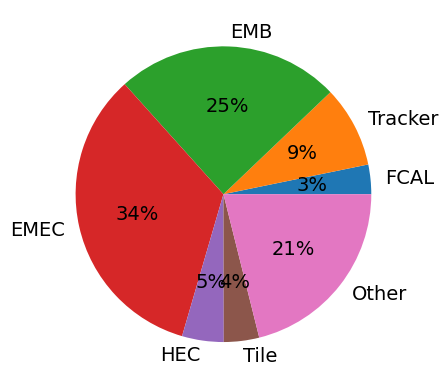

In [32]:
fig, ax = plt.subplots()

fcCost = 0
otherCost = 0
trackerCost = 0
embCost = 0
emecCost = 0
hecCost = 0
tileCost = 0
for index, volName in enumerate(volNames):
    if 'FC' in volName:
        fcCost+=totalCosts[index]
    elif 'TRT' in volName or 'SCT' in volName or 'Pixel' in volName:
        trackerCost+=totalCosts[index]
    elif 'EMB' in volName:
        embCost+=totalCosts[index]
    elif 'EMEC' in volName:
        emecCost+=totalCosts[index]
    elif 'HEC' in volName:
        hecCost+=totalCosts[index]
    elif 'Tile' in volName:
        tileCost+=totalCosts[index]
    else:
        otherCost+=totalCosts[index]
        print(volName, round(100*totalCosts[index]/sum(totalCosts)))
combinedVolNames = ['FCAL', 'Tracker', 'EMB', 'EMEC', 'HEC', 'Tile', 'Other']
combinedCosts = [trackerCost, fcCost, embCost, emecCost, hecCost, tileCost, otherCost]        
ax.pie(combinedCosts, labels=combinedVolNames, autopct='%1.0f%%')
plt.savefig(f'volCost.pdf', bbox_inches='tight')
plt.savefig(f'volCost.svg', bbox_inches='tight')
